In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

In [2]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

#transform_test = ...

In [4]:
train_set = torchvision.datasets.MNIST('./', train=True, transform = transform_train, download=True)

test_set = torchvision.datasets.MNIST('./', train=True, transform = transform_train, download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 181kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.37MB/s]


In [104]:
train_loader=DataLoader(train_set,batch_size=128,shuffle=True)
test_loader=DataLoader(test_set,batch_size=256,shuffle=False)

In [105]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)
    
    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy(),cmap='gray')
    ax.set_title(classes[labels[i]])
    ax.axis('off')
classes = ['0','1','2','3','4','5','6','7','8','9']


In [106]:
x_batch,y_batch=next(iter(train_loader))
print(x_batch[0].shape)
y_batch[0]

torch.Size([1, 28, 28])


tensor(9)

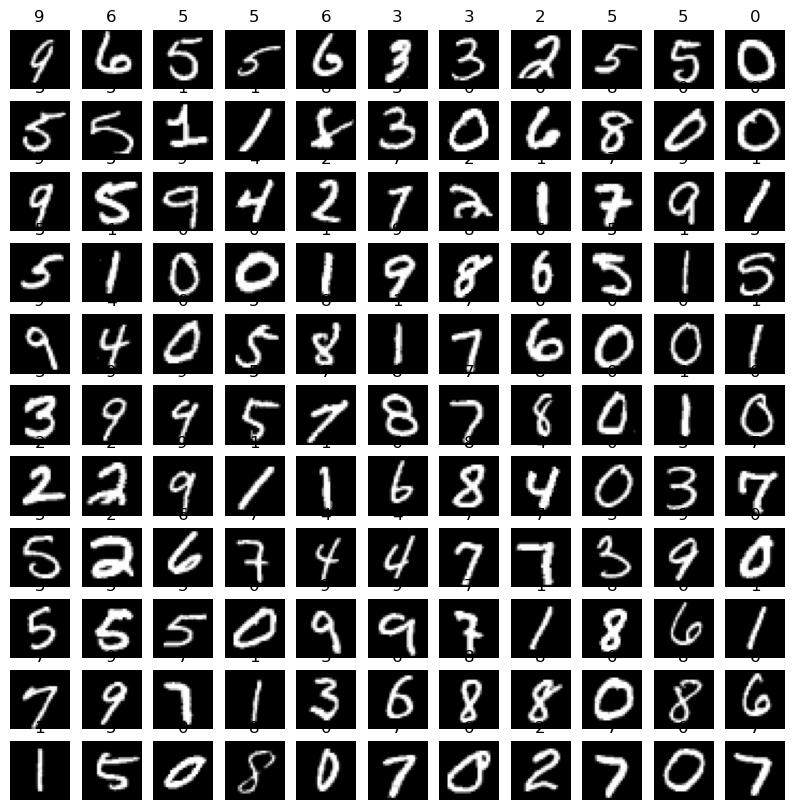

In [107]:
 x=normalize_image(x_batch)
plot_images(x, y_batch, classes, normalize=True)

In [126]:
def CNN():
    network=nn.Sequential(nn.Conv2d(1,32,3,padding=1,stride=2),
                          nn.BatchNorm2d(32),
                          nn.ReLU(),
                          nn.Conv2d(32,32,3,padding=1,stride=1),
                          nn.BatchNorm2d(32),
                          nn.ReLU(),
                          nn.Conv2d(32,64,1,padding=1,stride=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU(),
                          nn.Conv2d(64,64,1,padding=1,stride=2),
                          nn.BatchNorm2d(64),
                          nn.ReLU(),
                          nn.Conv2d(64,128,1,padding=1,stride=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),
                          nn.Conv2d(128,128,3,padding=1,stride=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),
                          nn.Conv2d(128,128,1,padding=1,stride=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),
                          nn.Conv2d(128,128,3,padding=1,stride=2),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),
                          nn.Conv2d(128,256,1,padding=1,stride=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),
                          nn.Conv2d(256,256,3,padding=1,stride=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),
                          nn.Conv2d(256,256,1,padding=1,stride=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),
                          nn.Conv2d(256,256,3,padding=1,stride=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),
                          nn.Conv2d(256,512,1,padding=1,stride=1),
                          nn.BatchNorm2d(512),
                          nn.ReLU(),
                          nn.Conv2d(512,512,3,padding=1,stride=1),
                          nn.BatchNorm2d(512),
                          nn.ReLU(),
                          nn.Conv2d(512,512,1,padding=1,stride=1),
                          nn.BatchNorm2d(512),
                          nn.ReLU(),
                          nn.Conv2d(512,512,3,padding=1,stride=2),
                          nn.BatchNorm2d(512),
                          nn.ReLU(),
                          nn.Conv2d(512,1024,1,padding=1,stride=1),
                          nn.BatchNorm2d(1024),
                          nn.ReLU(),
                          nn.Conv2d(1024,1024,3,padding=1,stride=1),
                          nn.BatchNorm2d(1024),
                          nn.ReLU(),
                          nn.Conv2d(1024,1024,1,padding=1,stride=1),
                          nn.BatchNorm2d(1024),
                          nn.ReLU(),
                          nn.AdaptiveAvgPool2d((1,1)),
                          nn.Flatten(),
                          nn.Linear(1024,10)        
    )
    return network



    

In [127]:
model=CNN()
model(torch.randn(10,1,28,28)).shape

torch.Size([10, 10])

In [128]:
def num_p(model):
    return sum(p.numel() for p in model.parameters())

In [129]:
num_p(model)

17765738

backward_pass

In [130]:
loss_fn=nn.CrossEntropyLoss() 
optimizer=optim.SGD(model.parameters(),lr=0.01)

In [131]:
device='cuda' if torch.cuda.is_available else 'cpu'
model=model.to(device)

In [132]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [133]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=10).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [134]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=10).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

backward_pass

In [122]:
l,mini_train_dataset=random_split(train_set,(len(train_set)-1000,1000))
mini_train_loader=DataLoader(mini_train_dataset,batch_size=20)

In [118]:
N=4
for n_ep in range(N):
    model,_,_=train_one_epoch(model,mini_train_loader,loss_fn,optimizer, epoch=n_ep)

Epoch 3: 100%|██████████| 50/50 [00:01<00:00, 36.26batch/s, accuracy=75.7, loss=1.04]


In [119]:
for lr in [0.1,0.01,0.001,0.0001]:
    print(f' lr : {lr}')
    
    optimizer=optim.SGD(model.parameters(),lr,weight_decay=0.1)
    loss_fn=nn.CrossEntropyLoss()
    for n_ep in range(N):
        model,_,_=train_one_epoch(model,mini_train_loader,loss_fn,optimizer,epoch=n_ep)

 lr : 0.1


Epoch 3: 100%|██████████| 50/50 [00:01<00:00, 36.07batch/s, accuracy=72.4, loss=1.21]


 lr : 0.01


Epoch 3: 100%|██████████| 50/50 [00:01<00:00, 36.18batch/s, accuracy=89.2, loss=1]    


 lr : 0.001


Epoch 3: 100%|██████████| 50/50 [00:01<00:00, 35.72batch/s, accuracy=89.7, loss=0.973]


 lr : 0.0001


Epoch 3: 100%|██████████| 50/50 [00:01<00:00, 35.26batch/s, accuracy=89.9, loss=0.969]


In [135]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [136]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 469/469 [00:49<00:00,  9.43batch/s, accuracy=75.1, loss=0.887]


Valid: Loss = 0.1445, Acc = 0.968



Epoch 1: 100%|██████████| 469/469 [00:52<00:00,  8.96batch/s, accuracy=97.5, loss=0.105]


Valid: Loss = 0.06154, Acc = 0.987



Epoch 2: 100%|██████████| 469/469 [00:52<00:00,  8.96batch/s, accuracy=98.7, loss=0.0552]


Valid: Loss = 0.03426, Acc = 0.9927



Epoch 3: 100%|██████████| 469/469 [00:51<00:00,  9.18batch/s, accuracy=99.2, loss=0.033] 


Valid: Loss = 0.02141, Acc = 0.9955



Epoch 4: 100%|██████████| 469/469 [00:50<00:00,  9.30batch/s, accuracy=99.6, loss=0.0202]


Valid: Loss = 0.009661, Acc = 0.9987



Epoch 5: 100%|██████████| 469/469 [00:50<00:00,  9.35batch/s, accuracy=99.8, loss=0.0129]


Valid: Loss = 0.00899, Acc = 0.9989



Epoch 6: 100%|██████████| 469/469 [00:50<00:00,  9.37batch/s, accuracy=99.9, loss=0.00777]


Valid: Loss = 0.004195, Acc = 0.9998



Epoch 7: 100%|██████████| 469/469 [00:49<00:00,  9.54batch/s, accuracy=100, loss=0.00473]


Valid: Loss = 0.002499, Acc = 0.9999



Epoch 8: 100%|██████████| 469/469 [00:49<00:00,  9.57batch/s, accuracy=100, loss=0.00332]


Valid: Loss = 0.001598, Acc = 1.0



Epoch 9: 100%|██████████| 469/469 [00:48<00:00,  9.68batch/s, accuracy=100, loss=0.0026] 


Valid: Loss = 0.001409, Acc = 1.0



In [137]:

!apt-get update

# نصب Git
!apt-get install git -y

# بررسی نسخه Git نصب شده
!git --version


Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
git version 2.34.1
